In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# Classifying newswires: a multi-class classification example


In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.


In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step



Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

### Class weight distribution


In [5]:
import numpy
classes, count = numpy.unique(train_labels, return_counts=True)
classes=classes.reshape(-1,1)
count=count.reshape(-1,1)
print(numpy.concatenate((classes,count), axis=1))

[[   0   55]
 [   1  432]
 [   2   74]
 [   3 3159]
 [   4 1949]
 [   5   17]
 [   6   48]
 [   7   16]
 [   8  139]
 [   9  101]
 [  10  124]
 [  11  390]
 [  12   49]
 [  13  172]
 [  14   26]
 [  15   20]
 [  16  444]
 [  17   39]
 [  18   66]
 [  19  549]
 [  20  269]
 [  21  100]
 [  22   15]
 [  23   41]
 [  24   62]
 [  25   92]
 [  26   24]
 [  27   15]
 [  28   48]
 [  29   19]
 [  30   45]
 [  31   39]
 [  32   32]
 [  33   11]
 [  34   50]
 [  35   10]
 [  36   49]
 [  37   19]
 [  38   19]
 [  39   24]
 [  40   36]
 [  41   30]
 [  42   13]
 [  43   21]
 [  44   12]
 [  45   18]]


### Clearly the data is imbalanced.

# Similarily, we take a look at test labels distributions.

In [6]:
classes, count = numpy.unique(test_labels, return_counts=True)
classes=classes.reshape(-1,1)
count=count.reshape(-1,1)
print(numpy.concatenate((classes,count), axis=1))

[[  0  12]
 [  1 105]
 [  2  20]
 [  3 813]
 [  4 474]
 [  5   5]
 [  6  14]
 [  7   3]
 [  8  38]
 [  9  25]
 [ 10  30]
 [ 11  83]
 [ 12  13]
 [ 13  37]
 [ 14   2]
 [ 15   9]
 [ 16  99]
 [ 17  12]
 [ 18  20]
 [ 19 133]
 [ 20  70]
 [ 21  27]
 [ 22   7]
 [ 23  12]
 [ 24  19]
 [ 25  31]
 [ 26   8]
 [ 27   4]
 [ 28  10]
 [ 29   4]
 [ 30  12]
 [ 31  13]
 [ 32  10]
 [ 33   5]
 [ 34   7]
 [ 35   6]
 [ 36  11]
 [ 37   2]
 [ 38   3]
 [ 39   5]
 [ 40  10]
 [ 41   8]
 [ 42   3]
 [ 43   6]
 [ 44   5]
 [ 45   1]]


Clealy, test labels follow similar distribution as train labels. Class labels 1,3 and 4 have highest distributions along with some other classes in 20s.

As with the IMDB reviews, each example is a list of integers (word indices):

In [7]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Example of actual sentence obtained from reverse indexing.

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 1us/step


In [9]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [10]:
train_labels[10]

3

## Preparing the data

Creating a sparse input matrix by marking the words present as 1. this will be input to our Dense neural network. We will limit maximum dimesions to 10000 as we have loaded only 10000 maximum frequncy words from the datasets. We donot create any embedding layer and encode words here.

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network
# 3 dense hidden layers with 512 units and tanh function: we start with a 3 layer network with 512 units and tanh actiavtion function. Since, we require probablities of classes at results we use softmax. Optimizer used is RMS prop and metrics for evaluating model is accuracy and categorical loss.

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(46, activation='softmax'))

In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7982 samples, validate on 1000 samples
Epoch 1/20





7982/7982 [==============================] - 6s 691us/step - loss: 1.9841 - acc: 0.5991 - val_loss: 0.9768 - val_acc: 0.8050
Epoch 2/20
7982/7982 [==============================] - 5s 572us/step - loss: 0.6090 - acc: 0.8717 - val_loss: 0.8976 - val_acc: 0.7930
Epoch 3/20
7982/7982 [==============================] - 4s 562us/step - loss: 0.3708 - acc: 0.9181 - val_loss: 0.8666 - val_acc: 0.8150
Epoch 4/20
7982/7982 [==============================] - 5s 571us/step - loss: 0.2454 - acc: 0.9402 - val_loss: 1.0331 - val_acc: 0.7790
Epoch 5/20
7982/7982 [==============================] - 5s 567us/step - loss: 0.2392 - acc: 0.9405 - val_loss: 1.2096 - val_acc: 0.7740
Epoch 6/20
7982/7982 [==============================] - 5s 567us/step - loss: 0.1778 - acc: 0.9524 - val_loss: 1.0076 - val_acc: 0.7840
Epoch 7/20
7982/7982 [============

Let's display its loss and accuracy curves:

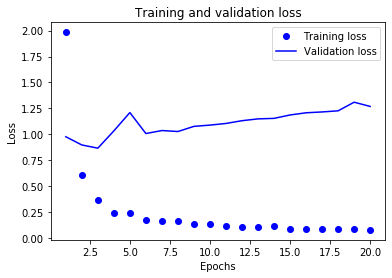

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

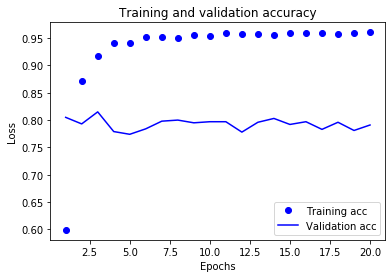

In [34]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

*It* seems that the network starts overfitting after 3 epochs. Let's train a new network from scratch for 3 epochs, then let's evaluate it on 
the test set:

In [35]:
model = models.Sequential()
model.add(layers.Dense(512, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(512, activation='tanh'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=3,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/3
7982/7982 [==============================] - 5s 623us/step - loss: 1.9921 - acc: 0.5883 - val_loss: 1.0232 - val_acc: 0.7700
Epoch 2/3
7982/7982 [==============================] - 5s 575us/step - loss: 0.6244 - acc: 0.8680 - val_loss: 0.9204 - val_acc: 0.8030
Epoch 3/3
2246/2246 [==============================] - 1s 387us/step


In [42]:
results

[0.9527861412783765, 0.7902938556904678]


#### Conclusion: 
Our approach reaches an accuracy of ~79% which is one of the highest accuracies of all the approaches. It is also a sligt improvement over our baseline of 77%.